In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

import bincounts
import srmse
import mape

In [2]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

# Filter to desired variables (numeric then categorical)
pums_data_h = h_df[['SERIALNO','HINCP','NP','VEH','BLD','ACCESS']]
pums_data_p = p_df[['SERIALNO','PWGTP','PINCP','AGEP','JWMNP','SEX','SCHL','MAR','COW','DPHY','DEYE','DREM','RAC1P']]
del h_df
del p_df
pums_data = pd.merge(pums_data_p, pums_data_h, on='SERIALNO')
pums_data = pums_data.drop(labels=['SERIALNO'], axis=1)

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)
pums_data['AGEP'], agep_bins = pd.qcut(pums_data['AGEP'], q=10, labels=False, retbins=True)
pums_data['JWMNP'], jwmnp_bins = pd.qcut(pums_data['JWMNP'], q=10, labels=False, retbins=True)
pums_data['PINCP'], pincp_bins = pd.qcut(pums_data['PINCP'], q=10, labels=False, retbins=True)

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

# Scale by the person-weights to get true population
pums_data = pums_data.reindex(pums_data.index.repeat(pums_data['PWGTP']))
pums_data = pums_data.drop('PWGTP', axis=1)
pums_data_p = pums_data_p.drop('PWGTP', axis=1)
pums_data = pums_data.sample(150000)
pums_data

Dataset n=359075 pre-cleaning
Dataset n=150203 post-cleaning


,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
204543,4.0,9,6.0,2,18.0,3,2.0,2.0,2,2.0,1,4.0,2,2.0,2.0,1.0
6823,6.0,5,4.0,1,19.0,1,1.0,2.0,2,2.0,1,3.0,4,2.0,2.0,1.0
66528,8.0,6,9.0,2,20.0,1,1.0,2.0,2,2.0,1,7.0,2,2.0,2.0,1.0
169811,5.0,2,7.0,1,20.0,1,1.0,2.0,2,2.0,4,1.0,4,1.0,6.0,1.0
100277,9.0,6,5.0,1,18.0,1,1.0,2.0,2,2.0,1,9.0,3,4.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267818,5.0,2,9.0,1,19.0,5,2.0,2.0,2,2.0,1,8.0,2,2.0,2.0,1.0
150896,4.0,3,8.0,1,20.0,1,1.0,2.0,2,2.0,2,2.0,7,2.0,5.0,1.0
316333,8.0,4,8.0,1,21.0,3,3.0,2.0,2,2.0,1,7.0,4,2.0,2.0,1.0
260252,7.0,5,4.0,1,15.0,3,1.0,2.0,2,2.0,1,3.0,4,2.0,2.0,1.0


In [3]:
popsim_data_p = pd.read_csv('./populationsim-master/example_wa_16/output/synthetic_persons.csv')[['household_id','PINCP','AGEP','JWMNP','SEX','SCHL','MAR','COW','DPHY','DEYE','DREM','RAC1P']].dropna()
popsim_data_h = pd.read_csv('./populationsim-master/example_wa_16/output/synthetic_households.csv')[['household_id','HINCP','NP','VEH','BLD','ACCESS']].dropna()
popsim_data = pd.merge(popsim_data_p,popsim_data_h, on='household_id')
popsim_data = popsim_data.drop(labels='household_id', axis=1)

# Convert numerical variables to categorical bins
popsim_data['HINCP'] = pd.cut(popsim_data['HINCP'], bins=hincp_bins, labels=False)
popsim_data['AGEP'] = pd.cut(popsim_data['AGEP'], bins=agep_bins, labels=False)
popsim_data['JWMNP'] = pd.cut(popsim_data['JWMNP'], bins=jwmnp_bins, labels=False)
popsim_data['PINCP'] = pd.cut(popsim_data['PINCP'], bins=pincp_bins, labels=False)

# Remove NA values and check n before/after
print(f"Dataset n={len(popsim_data)} pre-cleaning")
popsim_data = popsim_data.dropna()
print(f"Dataset n={len(popsim_data)} post-cleaning")
popsim_data

Dataset n=3257534 pre-cleaning
Dataset n=3228874 post-cleaning


,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
0,9,5,1.0,1,16.0,1,1.0,2.0,2,2.0,1,9,5,3.0,2.0,1.0
1,9,9,0.0,1,22.0,1,7.0,2.0,2,2.0,1,9,3,3.0,2.0,1.0
2,9,9,0.0,1,22.0,1,7.0,2.0,2,2.0,1,9,3,3.0,2.0,1.0
3,9,9,0.0,1,22.0,1,7.0,2.0,2,2.0,1,9,3,3.0,2.0,1.0
4,9,9,0.0,1,22.0,1,7.0,2.0,2,2.0,1,9,3,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257529,2,3,9.0,2,21.0,5,3.0,2.0,2,2.0,1,0,1,0.0,9.0,1.0
3257530,2,3,9.0,2,21.0,5,3.0,2.0,2,2.0,1,0,1,0.0,9.0,1.0
3257531,2,3,9.0,2,21.0,5,3.0,2.0,2,2.0,1,0,1,0.0,9.0,1.0
3257532,2,3,9.0,2,21.0,5,3.0,2.0,2,2.0,1,0,1,0.0,9.0,1.0


In [4]:
popsim_data_h

,household_id,HINCP,NP,VEH,BLD,ACCESS
0,1,249400.0,5,3.0,2.0,1.0
1,2,369000.0,3,3.0,2.0,1.0
2,3,369000.0,3,3.0,2.0,1.0
3,4,369000.0,3,3.0,2.0,1.0
4,5,369000.0,3,3.0,2.0,1.0
...,...,...,...,...,...,...
2848391,2848392,8000.0,1,0.0,9.0,1.0
2848392,2848393,8000.0,1,0.0,9.0,1.0
2848393,2848394,8000.0,1,0.0,9.0,1.0
2848394,2848395,8000.0,1,0.0,9.0,1.0


In [5]:
popsim_data_p

,household_id,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P
0,1,124700.0,42,10.0,1,16.0,1,1.0,2.0,2,2.0,1
1,2,301000.0,76,5.0,1,22.0,1,7.0,2.0,2,2.0,1
2,3,301000.0,76,5.0,1,22.0,1,7.0,2.0,2,2.0,1
3,4,301000.0,76,5.0,1,22.0,1,7.0,2.0,2,2.0,1
4,5,301000.0,76,5.0,1,22.0,1,7.0,2.0,2,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3257529,2848392,8000.0,29,90.0,2,21.0,5,3.0,2.0,2,2.0,1
3257530,2848393,8000.0,29,90.0,2,21.0,5,3.0,2.0,2,2.0,1
3257531,2848394,8000.0,29,90.0,2,21.0,5,3.0,2.0,2,2.0,1
3257532,2848395,8000.0,29,90.0,2,21.0,5,3.0,2.0,2,2.0,1


In [6]:
vae_data = pd.read_csv('./data/synthetic_populations/wa_persons_100000.csv')[['PINCP','AGEP','JWMNP','SEX','SCHL','MAR','COW','DPHY','DEYE','DREM','RAC1P','HINCP','NP','VEH','BLD','ACCESS']].dropna()
vae_data

,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
0,7.0,8,4.0,1,22.0,5,3.0,2.0,2,2.0,1,3.0,1,1.0,2.0,1.0
1,1.0,3,8.0,1,16.0,3,1.0,2.0,2,2.0,1,0.0,2,2.0,2.0,1.0
2,1.0,2,1.0,2,16.0,5,1.0,2.0,2,2.0,1,0.0,2,2.0,2.0,1.0
3,5.0,8,5.0,2,24.0,1,5.0,2.0,2,2.0,6,7.0,2,3.0,2.0,1.0
4,7.0,5,0.0,2,19.0,5,1.0,2.0,2,2.0,1,7.0,2,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268700,9.0,7,4.0,1,16.0,1,2.0,2.0,2,2.0,1,8.0,2,0.0,7.0,1.0
268701,7.0,8,1.0,2,24.0,3,5.0,2.0,2,2.0,6,8.0,2,0.0,7.0,1.0
268702,3.0,6,1.0,2,24.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0
268703,5.0,8,1.0,2,22.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0


In [7]:
# Time Tests
num_variables = [4,8,16]
time_vae_train_hh = [51,57,63]
time_vae_gen_hh = [52,48,54]
time_vae_train_p = [134,95,120]
time_vae_gen_p = [129,210,449]
time_vae = []
for i in range(len(num_variables)):
    z = time_vae_train_hh[i]+time_vae_gen_hh[i]+time_vae_train_p[i]+time_vae_gen_p[i]
    time_vae.append(z)
time_pop = [245,588,924]
time_vae

[366, 410, 686]

In [8]:
print((924-686)/(924)) # pct improvement

0.25757575757575757


### MAPE Accuracy Tests

In [9]:
# MAPE for the recreated popsim data
print("POPSIM")
mape_uni_pop = mape.calculateMAPE(popsim_data.sample(len(pums_data), replace=True), pums_data)

POPSIM
PINCP MAPE: 25.321163940222384
AGEP MAPE: 118.78989756694199
JWMNP MAPE: 11.579906633223228
SEX MAPE: 6.086989179572304
SCHL MAPE: 27.452443096444874
MAR MAPE: 70.53612136268956
COW MAPE: 26.559578392903365
DPHY MAPE: 445.6346203549057
DEYE MAPE: 220.32564977064916
DREM MAPE: 343.6306143206282
RAC1P MAPE: 22.70470098939277
HINCP MAPE: 35.18032001789307
NP MAPE: 61.119530136630615
VEH MAPE: 45.745674097991326
BLD MAPE: 32.625813410498814
ACCESS MAPE: 45.25888758713732
Univariate (marginal) MAPE: 54.4430760798088, Total Bins: 131


In [10]:
# MAPE for the recreated cvae data
print("CVAE")
mape_uni_cvae = mape.calculateMAPE(vae_data.sample(len(pums_data), replace=True), pums_data)

CVAE
PINCP MAPE: 42.671821290059704
AGEP MAPE: 22.087712104005373
JWMNP MAPE: 42.88298188198439
SEX MAPE: 1.269018945564544
SCHL MAPE: 67.92435589577389
MAR MAPE: 13.829508479196981
COW MAPE: 74.60384379887606
DPHY MAPE: 50.94174302267926
DEYE MAPE: 50.587489376627225
DREM MAPE: 50.889549322151204
RAC1P MAPE: 61.34094755378968
HINCP MAPE: 24.251593084747388
NP MAPE: 254.86943620539995
VEH MAPE: 28.409520553058183
BLD MAPE: 107.90280529313019
ACCESS MAPE: 55.67874165597942
Univariate (marginal) MAPE: 80.03848174485137, Total Bins: 131


In [11]:
print("Net Difference")
np.subtract(mape_uni_pop,mape_uni_cvae)

Net Difference


array([ -17.35065735,   96.70218546,  -31.30307525,    4.81797023,
        -40.4719128 ,   56.70661288,  -48.04426541,  394.69287733,
        169.73816039,  292.741065  ,  -38.63624656,   10.92872693,
       -193.74990607,   17.33615354,  -75.27699188,  -10.41985407])

### SRMSE Accuracy Tests

In [12]:
# SRMSE for the recreated popsim data
print("POPSIM")
srmse_uni_pop = srmse.calculateSRMSE(popsim_data.sample(len(pums_data), replace=True), pums_data)
srmse_bi_pop = srmse.calculateBivariateSRMSE(popsim_data.sample(len(pums_data), replace=True), pums_data)

POPSIM
Univariate (marginal) SRMSE: 0.3172555285400652, Total Bins: 131
Bivariate (joint) SRMSE: 0.8637135360685277, Total Bins: 7768


In [13]:
# SRMSE for the recreated cvae data
print("CVAE")
srmse_uni_cvae = srmse.calculateSRMSE(vae_data.sample(len(pums_data), replace=True), pums_data)
srmse_bi_cvae = srmse.calculateBivariateSRMSE(vae_data.sample(len(pums_data), replace=True), pums_data)

CVAE
Univariate (marginal) SRMSE: 0.29428535112094006, Total Bins: 131
Bivariate (joint) SRMSE: 0.8418908340916333, Total Bins: 7768


In [14]:
print((srmse_uni_pop-srmse_uni_cvae)/(srmse_uni_pop)*100) # pct difference
print((srmse_bi_pop-srmse_bi_cvae)/(srmse_bi_pop)*100) # pct difference

7.2402764814937886
2.5266134042807185


### SRMSE Sparse Data Test Results

In [15]:
# Data Tests for VAE
num_samples = [100000,10000,1000,100,10,1]
srmse_uni_vae = [.0379,.0341,.0442,.0555,.1289,.2314]
srmse_bi_vae = [.0061,.0058,.0091,.0111,.0200,.0351]

In [16]:
# Reset the index in PUMS data because it was duplicated when weighting
pums_data.reset_index(inplace=True)

In [17]:
all_pops = []
for num in num_samples:
    pop = pd.read_csv(f"./data/synthetic_populations/wa_persons_{num}.csv")
    pop['num_samples'] = num
    all_pops.append(pop)
all_pops = pd.concat(all_pops)

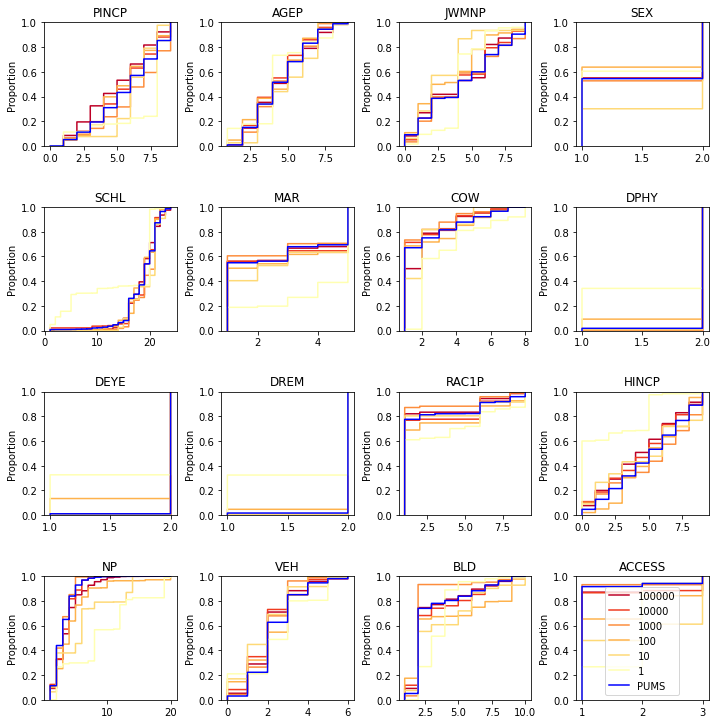

In [18]:
colors = ['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026']
colors.reverse()

# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
fig.tight_layout(h_pad=4)

# Plot distribution of each variable for each number of population sample size
for j, popsize in enumerate(num_samples):
    data_subset = all_pops[all_pops['num_samples']==popsize]
    for i, var in enumerate(data_subset.columns[:-1]):
        sns.ecdfplot(data=data_subset, x=var, color=colors[j], ax=axes.flatten()[i])
        axes.flatten()[i].set_title(var)
        axes.flatten()[i].set_xlabel(None)

# Plot the PUMS data distribution on top
for i, var in enumerate(data_subset.columns[:-1]):
    sns.ecdfplot(data=pums_data, x=var, color='blue', ax=axes.flatten()[i])
    axes.flatten()[i].set_title(var)
    axes.flatten()[i].set_xlabel(None)

# Add legend with label for PUMS
plt.legend(labels=num_samples+['PUMS'])

IndexError: index 16 is out of bounds for axis 0 with size 16

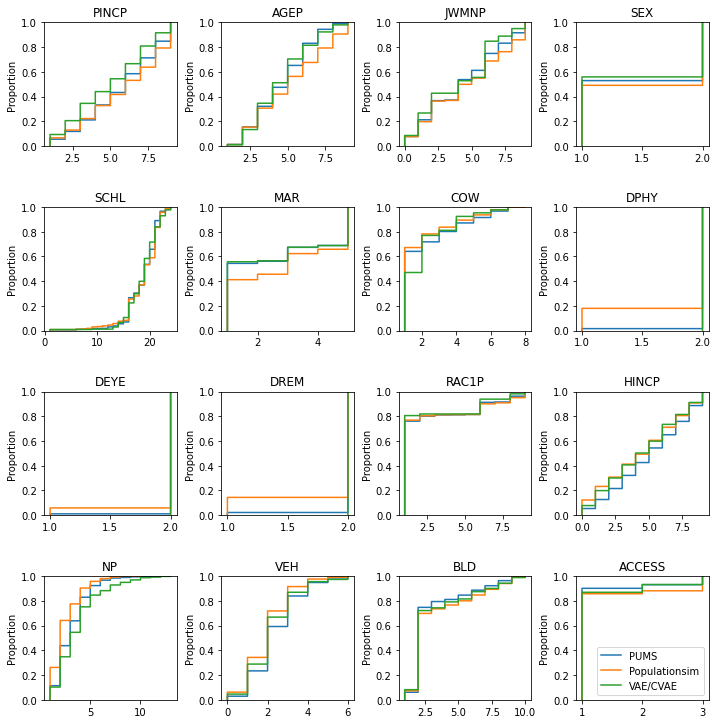

In [33]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
fig.tight_layout(h_pad=4)

for i, var in enumerate(vae_data.columns):
    sns.ecdfplot(data=pums_data.sample(1000), x=var, ax=axes.flatten()[i])
    sns.ecdfplot(data=popsim_data.sample(1000), x=var, ax=axes.flatten()[i])
    sns.ecdfplot(data=vae_data.sample(1000), x=var, ax=axes.flatten()[i])
    axes.flatten()[i].set_title(var)
    axes.flatten()[i].set_xlabel(None)
    plt.legend(labels=['PUMS','Populationsim','VAE/CVAE'])

### Determine Statistical Significance Between Outputs

In [20]:
PINCP_bins = [i for i in range(0,11)]
AGEP_bins = [i for i in range(1,11)]
JWMNP_bins = [i for i in range(0,11)]
SEX_bins = [i for i in range(1,4)]
SCHL_bins = [i for i in range(1,26)]
MAR_bins = [i for i in range(1,7)]
COW_bins = [i for i in range(1,10)]
DPHY_bins = [i for i in range(1,4)]
DEYE_bins = [i for i in range(1,4)]
DREM_bins = [i for i in range(1,4)]
RAC1P_bins = [i for i in range(1,11)]
HINCP_bins = [i for i in range(0,11)]
NP_bins = [i for i in range(1,22)]
VEH_bins = [i for i in range(0,8)]
BLD_bins = [i for i in range(1,12)]
ACCESS_bins = [i for i in range(1,5)]
bin_list = [PINCP_bins,AGEP_bins,JWMNP_bins,SEX_bins,SCHL_bins,MAR_bins,COW_bins,DPHY_bins,
           DEYE_bins,DREM_bins,RAC1P_bins,HINCP_bins,NP_bins,VEH_bins,BLD_bins,
           ACCESS_bins]

In [21]:
# Determine whether the generated variable distributions are statistically different
# from the weighted PUMS distribution
# Reload datasets first

chi_values_popsim = []
p_values_popsim = []
chi_values_vae = []
p_values_vae = []

# Sample is set to 150k when loading PUMS
sample_size = 150000

# Add 1 to each bin, chi-sq doesn't handle zeros in both obs/exp well

print("POPSIM")
for i,var in enumerate(vae_data.columns):
    f_exp = [x+1 for x in bincounts.get_bin_counts(pums_data[var],bin_list[i])]
    f_obs = [x+1 for x in bincounts.get_bin_counts(popsim_data[var].sample(sample_size),bin_list[i])]
    result = scipy.stats.chisquare(f_exp=f_exp, f_obs=f_obs)
    chi_values_popsim.append(int(result[0]))
    p_values_popsim.append(result[1])
print(chi_values_popsim)
    
print("VAE")
for i,var in enumerate(vae_data.columns):
    f_exp = [x+1 for x in bincounts.get_bin_counts(pums_data[var],bin_list[i])]
    f_obs = [x+1 for x in bincounts.get_bin_counts(vae_data[var].sample(sample_size),bin_list[i])]
    result = scipy.stats.chisquare(f_exp=f_exp, f_obs=f_obs)
    chi_values_vae.append(int(result[0]))
    p_values_vae.append(result[1])
print(chi_values_vae)

POPSIM
[7222, 112590, 3583, 441, 2403, 16485, 2472, 210674, 32694, 123953, 1265, 28770, 34343, 16265, 3861, 10638]
VAE
[21932, 5268, 31516, 23, 32011, 793, 95623, 2824, 1761, 2667, 8461, 10850, 56324, 7262, 19549, 9188]


In [22]:
print(np.mean(chi_values_vae))

19128.25


In [23]:
print(p_values_popsim)
print(p_values_vae)

[0.0, 0.0, 0.0, 4.746874839608603e-98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.718048013602908e-268, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.3835408125022774e-06, 0.0, 1.6548818404301575e-170, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [24]:
diffs = []
for i,val in enumerate(chi_values_vae):
    diffs.append(val-chi_values_popsim[i])
print(diffs)
print(np.mean(diffs))

[14710, -107322, 27933, -418, 29608, -15692, 93151, -207850, -30933, -121286, 7196, -17920, 21981, -9003, 15688, -1450]
-18850.4375


### Compare households from CVAE and VAE

In [25]:
vae_data

,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
0,7.0,8,4.0,1,22.0,5,3.0,2.0,2,2.0,1,3.0,1,1.0,2.0,1.0
1,1.0,3,8.0,1,16.0,3,1.0,2.0,2,2.0,1,0.0,2,2.0,2.0,1.0
2,1.0,2,1.0,2,16.0,5,1.0,2.0,2,2.0,1,0.0,2,2.0,2.0,1.0
3,5.0,8,5.0,2,24.0,1,5.0,2.0,2,2.0,6,7.0,2,3.0,2.0,1.0
4,7.0,5,0.0,2,19.0,5,1.0,2.0,2,2.0,1,7.0,2,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268700,9.0,7,4.0,1,16.0,1,2.0,2.0,2,2.0,1,8.0,2,0.0,7.0,1.0
268701,7.0,8,1.0,2,24.0,3,5.0,2.0,2,2.0,6,8.0,2,0.0,7.0,1.0
268702,3.0,6,1.0,2,24.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0
268703,5.0,8,1.0,2,22.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0


In [26]:
def getBin(val, var):
    switcher = {
        'HINCP': f"{hincp_bins[int(val)-1]} - {hincp_bins[int(val)]}",
        'AGEP': f"{agep_bins[int(val)-1]} - {agep_bins[int(val)]}",
        'JWMNP': f"{jwmnp_bins[int(val)-1]} - {jwmnp_bins[int(val)]}",
        'PINCP': f"{pincp_bins[int(val)-1]} - {pincp_bins[int(val)]}"
    }
    return switcher.get(var, "invalid")

In [27]:
vae_data['HINCP_val'] = vae_data['HINCP'].apply(getBin, args=('HINCP',))
vae_data['AGEP_val'] = vae_data['AGEP'].apply(getBin, args=('AGEP',))
vae_data['JWMNP_val'] = vae_data['JWMNP'].apply(getBin, args=('JWMNP',))
vae_data['PINCP_val'] = vae_data['PINCP'].apply(getBin, args=('PINCP',))

In [28]:
vae_data[vae_data['NP']==3].iloc[55660:,:]

,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS,HINCP_val,AGEP_val,JWMNP_val,PINCP_val
268679,7.0,3,1.0,2,19.0,5,1.0,2.0,2,2.0,1,8.0,3,5.0,2.0,1.0,112000.0 - 139800.0,17.0 - 25.0,1.0 - 6.0,35800.0 - 48000.0
268680,8.0,8,4.0,1,16.0,1,2.0,2.0,2,2.0,1,8.0,3,5.0,2.0,1.0,112000.0 - 139800.0,56.0 - 63.0,15.0 - 18.0,48000.0 - 64800.0
268691,3.0,2,0.0,2,16.0,5,1.0,2.0,2,2.0,1,1.0,3,2.0,1.0,1.0,-10200.0 - 21500.0,8.0 - 17.0,150.0 - 1.0,5000.0 - 11110.0
268692,3.0,4,2.0,2,16.0,1,1.0,2.0,2,2.0,1,1.0,3,2.0,1.0,1.0,-10200.0 - 21500.0,25.0 - 33.0,6.0 - 10.0,5000.0 - 11110.0
268693,3.0,2,1.0,2,22.0,1,4.0,2.0,2,2.0,1,1.0,3,2.0,1.0,1.0,-10200.0 - 21500.0,8.0 - 17.0,1.0 - 6.0,5000.0 - 11110.0
268702,3.0,6,1.0,2,24.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0,49000.0 - 62000.0,41.0 - 49.0,1.0 - 6.0,5000.0 - 11110.0
268703,5.0,8,1.0,2,22.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0,49000.0 - 62000.0,56.0 - 63.0,1.0 - 6.0,18000.0 - 26000.0
268704,2.0,3,6.0,1,19.0,5,1.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0,49000.0 - 62000.0,17.0 - 25.0,20.0 - 25.0,0.0 - 5000.0


In [29]:
non_cvae_data = pd.read_csv("data/synthetic_populations/wa_persons_100000_vae.csv")
non_cvae_data['HINCP_val'] = non_cvae_data['HINCP'].apply(getBin, args=('HINCP',))
non_cvae_data['AGEP_val'] = non_cvae_data['AGEP'].apply(getBin, args=('AGEP',))
non_cvae_data['JWMNP_val'] = non_cvae_data['JWMNP'].apply(getBin, args=('JWMNP',))
non_cvae_data['PINCP_val'] = non_cvae_data['PINCP'].apply(getBin, args=('PINCP',))

In [30]:
vae_data[vae_data['NP']==3]

,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS,HINCP_val,AGEP_val,JWMNP_val,PINCP_val
24,5.0,5,6.0,1,21.0,1,2.0,2.0,2,2.0,1,1.0,3,2.0,2.0,1.0,-10200.0 - 21500.0,33.0 - 41.0,20.0 - 25.0,18000.0 - 26000.0
25,1.0,4,7.0,1,19.0,1,1.0,2.0,2,2.0,1,1.0,3,2.0,2.0,1.0,-10200.0 - 21500.0,25.0 - 33.0,25.0 - 30.0,-10500.0 - 0.0
26,3.0,5,4.0,1,21.0,1,2.0,2.0,2,2.0,6,1.0,3,2.0,2.0,1.0,-10200.0 - 21500.0,33.0 - 41.0,15.0 - 18.0,5000.0 - 11110.0
33,5.0,3,0.0,2,16.0,1,6.0,2.0,2,2.0,1,4.0,3,2.0,7.0,3.0,49000.0 - 62000.0,17.0 - 25.0,150.0 - 1.0,18000.0 - 26000.0
34,3.0,4,7.0,1,20.0,1,1.0,2.0,2,2.0,1,4.0,3,2.0,7.0,3.0,49000.0 - 62000.0,25.0 - 33.0,25.0 - 30.0,5000.0 - 11110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268692,3.0,4,2.0,2,16.0,1,1.0,2.0,2,2.0,1,1.0,3,2.0,1.0,1.0,-10200.0 - 21500.0,25.0 - 33.0,6.0 - 10.0,5000.0 - 11110.0
268693,3.0,2,1.0,2,22.0,1,4.0,2.0,2,2.0,1,1.0,3,2.0,1.0,1.0,-10200.0 - 21500.0,8.0 - 17.0,1.0 - 6.0,5000.0 - 11110.0
268702,3.0,6,1.0,2,24.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0,49000.0 - 62000.0,41.0 - 49.0,1.0 - 6.0,5000.0 - 11110.0
268703,5.0,8,1.0,2,22.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0,49000.0 - 62000.0,56.0 - 63.0,1.0 - 6.0,18000.0 - 26000.0
